# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def line():
    print('-------------------------------------------------')

In [2]:
data_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

data_geo_0 = data_geo_0.drop(['id'], axis = 1)

data_geo_1 = data_geo_1.drop(['id'], axis = 1)

data_geo_2 = data_geo_2.drop(['id'], axis = 1)

line()
print(data_geo_0.info())
line()
print(data_geo_1.info())
line()
print(data_geo_2.info())
line()

-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float

## Обучение и проверка модели

In [3]:
# Разделим признаки и цели по каждому региону

features_geo_0 = data_geo_0.drop(['product'], axis = 1)
target_geo_0 = data_geo_0['product']

features_geo_1 = data_geo_1.drop(['product'], axis = 1)
target_geo_1 = data_geo_1['product']

features_geo_2 = data_geo_2.drop(['product'], axis = 1)
target_geo_2 = data_geo_2['product']

features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0 = train_test_split(
    features_geo_0, target_geo_0, test_size = 0.25, random_state = 12345)

features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1 = train_test_split(
    features_geo_1, target_geo_1, test_size = 0.25, random_state = 12345)

features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2 = train_test_split(
    features_geo_2, target_geo_2, test_size = 0.25, random_state = 12345)

# Проверим размерность наборов: тренировочного и тестового

print(target_train_geo_0.shape, target_valid_geo_0.shape)
print(target_train_geo_1.shape, target_valid_geo_1.shape)
print(target_train_geo_2.shape, target_valid_geo_2.shape)

(75000,) (25000,)
(75000,) (25000,)
(75000,) (25000,)


In [4]:
# Обучим модели, для удобства создадим массив с тренировочными и валидными наборами

mass_train_features = [features_train_geo_0, features_train_geo_1, features_train_geo_2]
mass_train_targets = [target_train_geo_0, target_train_geo_1, target_train_geo_2]

mass_valid_features = [features_valid_geo_0, features_valid_geo_1, features_valid_geo_2]
mass_valid_targets = [target_valid_geo_0, target_valid_geo_1, target_valid_geo_2]

mass_predictions = []

for num_geo in range(len(mass_train_features)):
    model = LinearRegression()
    model.fit(mass_train_features[num_geo], mass_train_targets[num_geo])
    predictions = model.predict(mass_valid_features[num_geo])
    mass_predictions.append(pd.Series(predictions))
    print('RMSE для региона №' + str(num_geo + 1), mean_squared_error(mass_valid_targets[num_geo], predictions) ** 0.5)
    print('Cредний запас предсказанного сырья для региона', predictions.mean(), '\n')

RMSE для региона №1 37.5794217150813
Cредний запас предсказанного сырья для региона 92.59256778438038 

RMSE для региона №2 0.893099286775616
Cредний запас предсказанного сырья для региона 68.728546895446 

RMSE для региона №3 40.02970873393434
Cредний запас предсказанного сырья для региона 94.96504596800489 



Комментарий: По полученным данным мы определили, что в среднем в первом и втором регионе наша модель предсказывает значения хуже чем во втором. НО самый большой запас сырья по предсказаниям находится в третьем регионе

## Подготовка к расчёту прибыли

In [5]:
# Ключевые значения

budget = 10 ** 10
revenue_barrel = 450000
count_borehole = 200

# Достаточное количество добычи нефти, для безубыточности

sufficient_volume = budget / revenue_barrel / count_borehole

print('Для безубыточной разработки необходимо чтобы одна скважина добывала не менее:', round(sufficient_volume + 1), 'тыс. баррелей \n')

# Рассчитаем средний запас по каждому региону

print('В среднем первый регион добывает:', round(data_geo_0['product'].mean()), 'тыс. баррелей')
print('В среднем второй регион добывает:', round(data_geo_1['product'].mean()), 'тыс. баррелей')
print('В среднем третий регион добывает:', round(data_geo_2['product'].mean()), 'тыс. баррелей')
print(budget)

Для безубыточной разработки необходимо чтобы одна скважина добывала не менее: 112 тыс. баррелей 

В среднем первый регион добывает: 93 тыс. баррелей
В среднем второй регион добывает: 69 тыс. баррелей
В среднем третий регион добывает: 95 тыс. баррелей
10000000000



<b>Комментарий:</b> При таком раскладе у нас не очень утешительный прогноз, действительно одна скважина должна добывать не менее 112 тыс. баррелей, а средние значения по каждому из регионов меньше. Т.е мы должны выбирать только самые лучшие месторождения и не имеем право на сильное отклонение

## Расчёт прибыли и рисков 

In [ ]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count].sum()
    price = selected * revenue_barrel
    return (price - budget) / 10 ** 9

for i in range(3):
    print('Прибыль региона №' +  str(i + 1), revenue(mass_valid_targets[i].reset_index(drop=True), mass_predictions[i], 200))

Прибыль региона №1 3.3208260431398524
Прибыль региона №2 2.4150866966815108
Прибыль региона №3 2.7103499635998327


<b>Комментарий:</b> Cамый прибыльный регион, это регион под №1

## Bootstrap

95%-й доверительный интервал: (-0.10209009483793655 : 0.9479763533583688)
Средняя прибыль: 0.42593852691059236
Риск убытка: 6.0


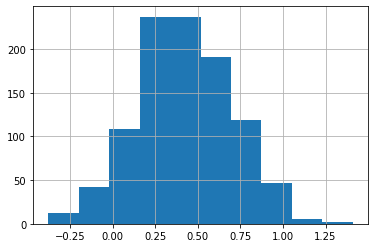

95%-й доверительный интервал: (0.1281232314330863 : 0.9536129820669086)
Средняя прибыль: 0.5182594936973248
Риск убытка: 0.3


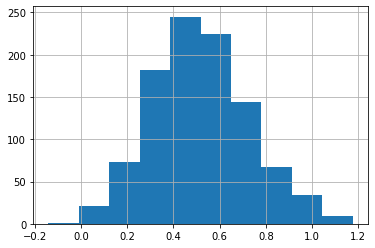

95%-й доверительный интервал: (-0.11585260916001143 : 0.989629939844574)
Средняя прибыль: 0.4201940053440501
Риск убытка: 6.2


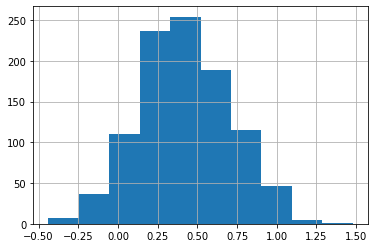

In [7]:
values = [[],[],[]]
state = np.random.RandomState(12345)

for i in range(3):
    for j in range(1000):
        target_sample = mass_valid_targets[i].reset_index(drop=True).sample(n = 500, replace = True, random_state=state)
        probs_subsample = mass_predictions[i][target_sample.index]
        
        values[i].append(revenue(target_sample, probs_subsample, 200))
        
    values[i] = pd.Series(values[i])
    values[i].hist()
    print('95%-й доверительный интервал: (' + str(values[i].quantile(0.025)) + ' : ' + str(values[i].quantile(0.975)) + ')')
    print('Средняя прибыль:', values[i].mean())
    print('Риск убытка:', stats.percentileofscore(values[i], 0))
    plt.show()

<b>Комментарий:</b> По полученным данным, можно дать следующие советы, если бизнесу важна маскимальная прибыль, то есть смысл попытать удачу и выбрать 3 регион, в котором мы можем получить прибыль до 10979 млрд., если нам необходимо просто заработать более чем 10000 млрд., то лучше выбрать 2 регион, а регион №1 уступает по всем параметрам